## QR Heston SPX and VIX smiles from simulation


We use the QRH scheme from `QRH SSR.pdf` to generate SPX and VIX smiles.

In [1]:
## The required packages
library(gsl)
library(MittagLeffleR)
library(statmod)
library(stinepack)
library(repr)


In [2]:
source("gammaKernel.R")
source("QRHGammaYFromXi.R")
source("QRHsimulation.R")
source("BlackScholes.R")
source("plotIvolsMC.R")


### Gamma kernel

The gamma kernel is given by
$$
\kappa(\tau)= \frac{\nu}{\Gamma(\alpha)}\, \tau^{\alpha-1}\,e^{-\lambda \tau},
$$

with $\alpha = H + \tfrac12$.

In [3]:
params0 <- list(al = 0.568, lam = 9.68, nu = 0.572, c = 8.1e-3)


### Kernel convergence condition

In [4]:
converge.test <- function(params) {
  al <- params$al
  H <- al - 1 / 2
  lam <- params$lam
  nu <- params$nu
  return(((nu / gamma(al))^2 * gamma(2 * al)) / (lam)^(2 * H))
}


In [5]:
converge.test(params0)


[1] 0.09171421

### Initial forward variance curve $\xi_t(u)$

In [6]:
load(file = "xi20230215.rData")


In [7]:
xi <- xiCurveObj$getForwardVarCurve()


In [8]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 150)


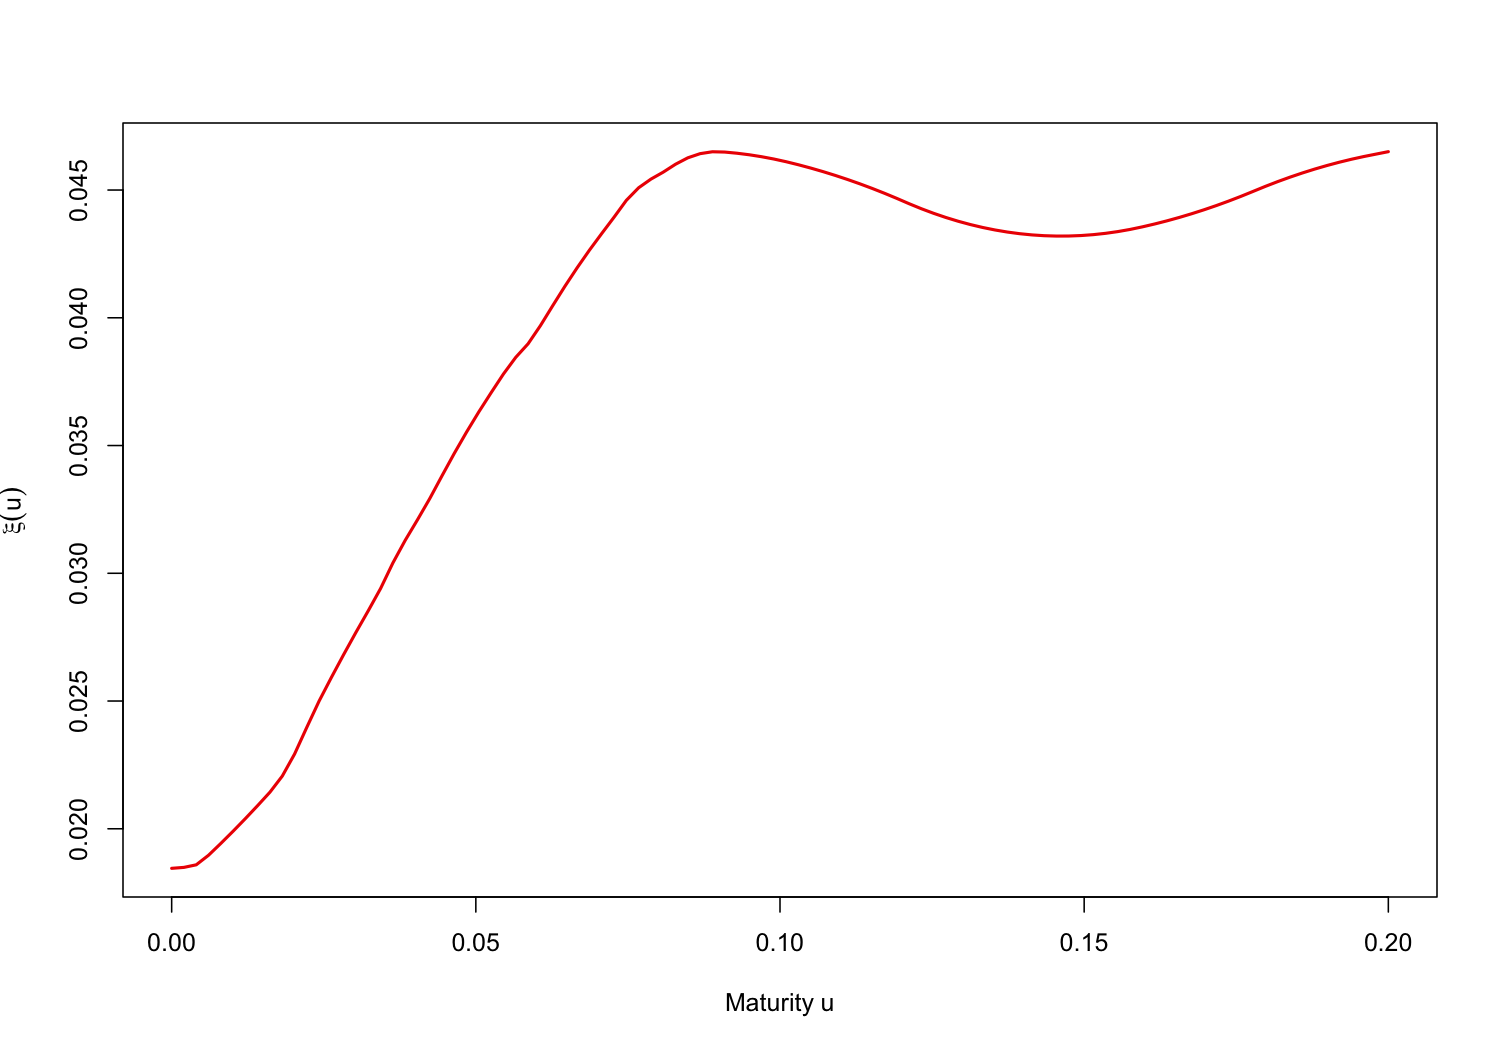

In [9]:
curve(xi,
  from = 0, to = .2, col = "red2", n = 100, lwd = 2,
  xlab = "Maturity u", ylab = expression(xi(u))
)


### $y_t(u)$ from $\xi_t(u)$

$$
y_t(u)^2= \xi_t(u) - c -  \int_t^u\,\xi_t(s)\,\kappa (u-s)^2\,ds.
$$

Integration is performed using Gauss-Jacobi quadrature.

In [10]:
ey <- yFromXi(params0, xi)


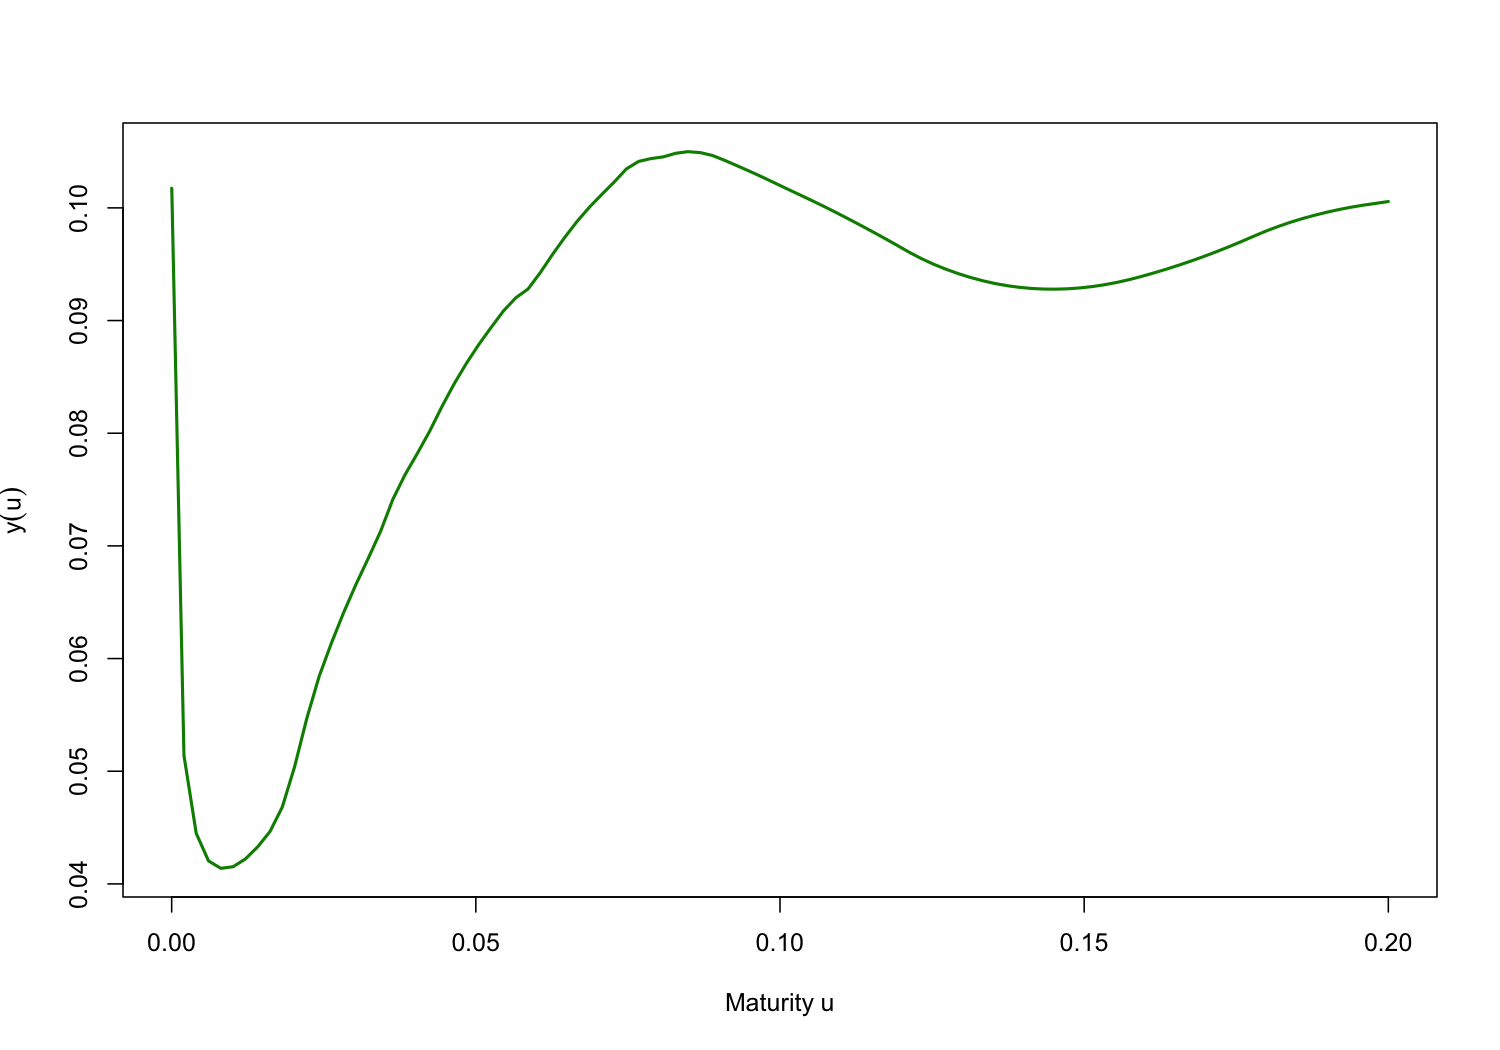

In [11]:
curve(ey,
  from = 0, to = .2, n = 100, col = "green4", lwd = 2,
  xlab = "Maturity u", ylab = expression(y(u))
)


### Load SPX and VIX implied volatility data

In [12]:
load("spxvixVols20230215.rData")


### Choose expiries

In [13]:
(spxExpiries <- c(7, 14, 20, 28) / 365)


[1] 0.01917808 0.03835616 0.05479452 0.07671233

In this particular case, we choose identical SPX and VIX expiries.

In [14]:
(vixExpiries <- spxExpiries)


[1] 0.01917808 0.03835616 0.05479452 0.07671233

### Run simulation

In [42]:
paths <- 1e5
steps <- 300


Change cell type from `RawNBConvert` to `Code` to run with more paths and steps.

The list `spx.all` has all variables of interest for each expiry.

In [43]:
system.time(
  qrh.all <- QRH.sim(params0, xi)(
    paths, steps, nvix = 10, expiries = spxExpiries, output = "all"
  )
)


   user  system elapsed 
 91.954  65.634 301.809 

In [44]:
(n.all <- length(qrh.all))


[1] 4

#### Extract log-SPX values from list `spx.all`

In [45]:
qrh.spx <- matrix(nrow = n.all, ncol = paths)
for (j in 1:n.all) {
  qrh.spx[j, ] <- qrh.all[[j]]$X
}


In [46]:
options(repr.plot.width = 13, repr.plot.height = 8, repr.plot.res = 150)


In [47]:
spxVolDataExtract <- spxIvols20230215[round(spxIvols20230215$Texp, 3) %in% round(spxExpiries, 3), ]


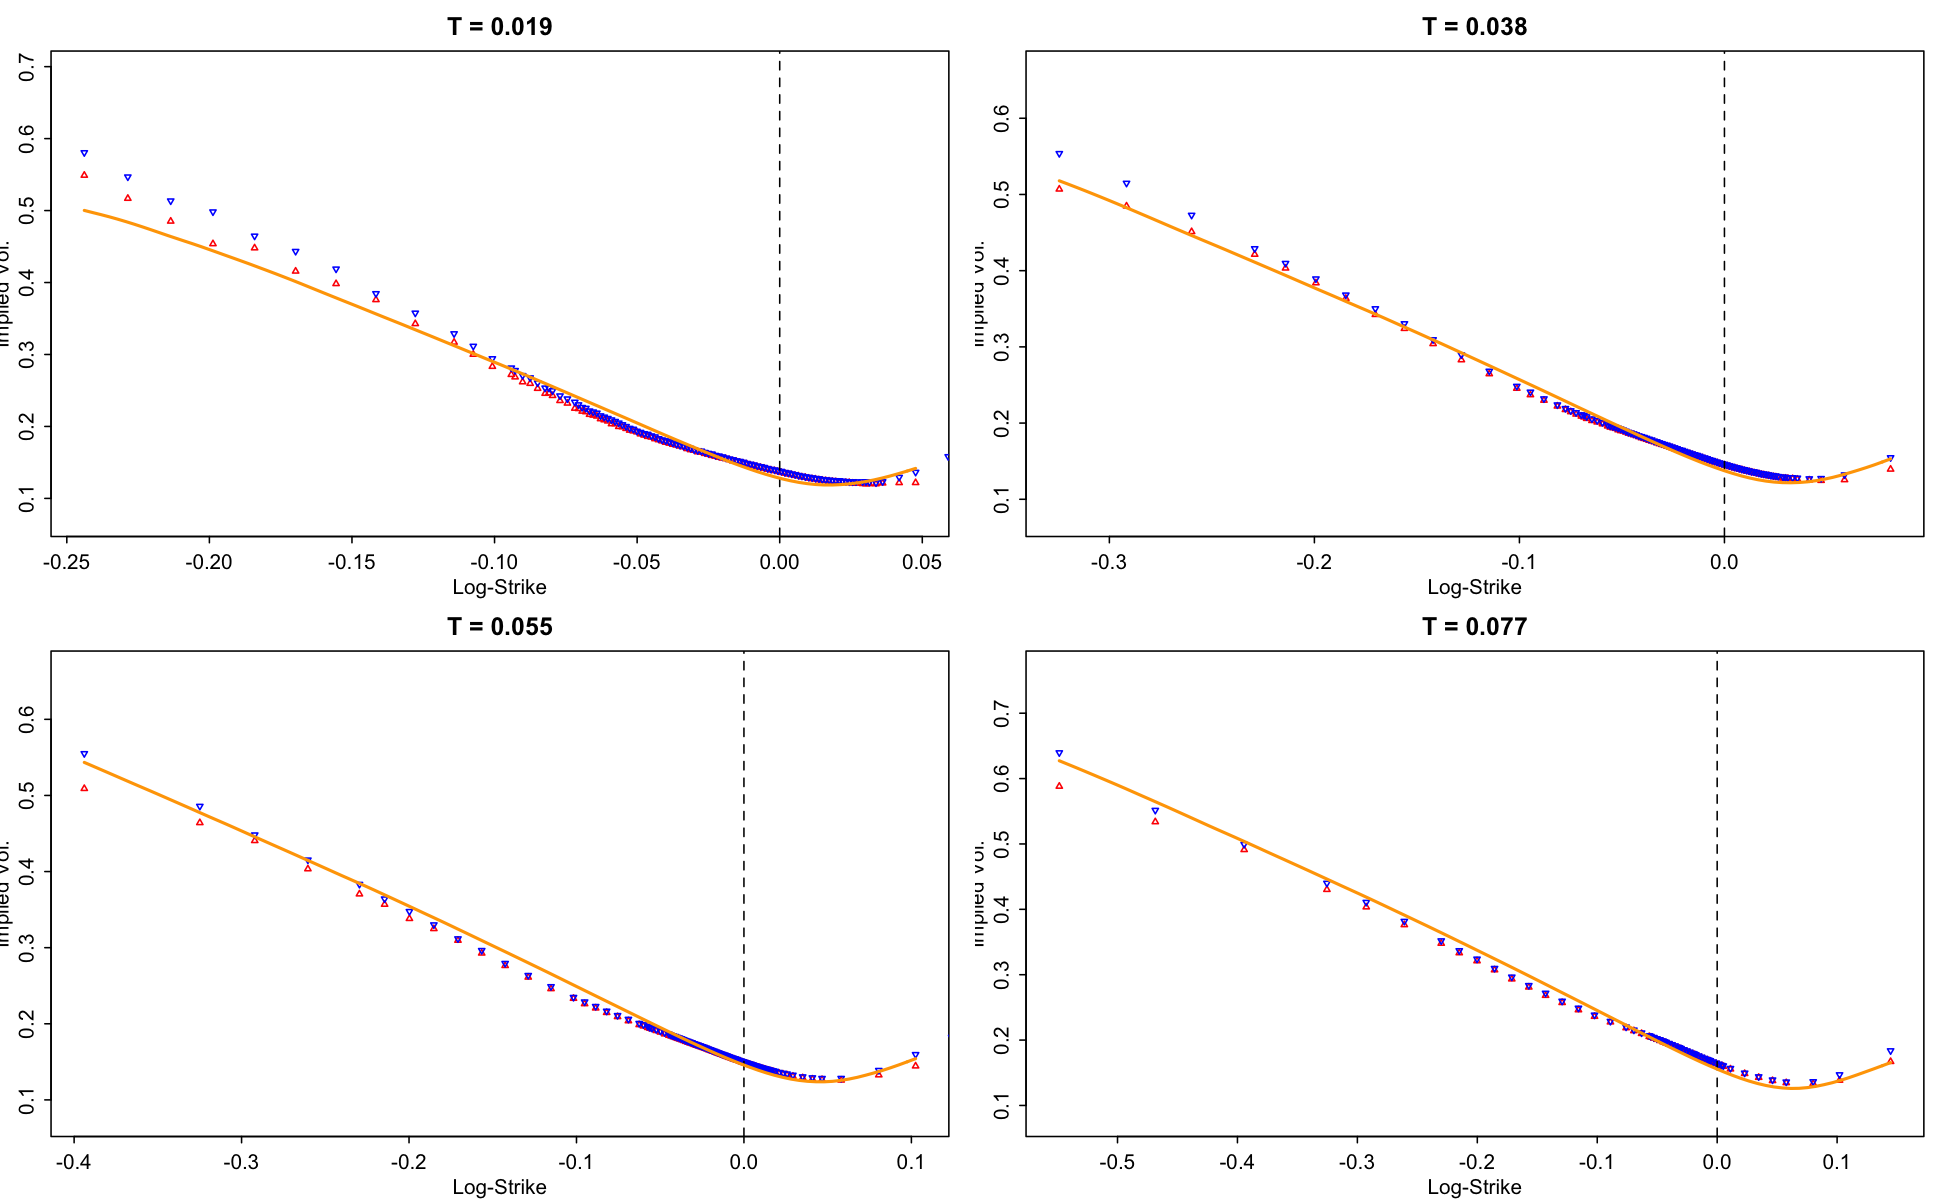

In [48]:
plot.spx <- plotIvolsMC(spxVolDataExtract, mcMatrix = exp(qrh.spx), colnum = 2)


### VIX smiles

#### Extract VIX values from list `spx.all`

In [49]:
qrh.vix <- matrix(nrow = n.all, ncol = paths)
for (j in 1:n.all) {
  qrh.vix[j, ] <- qrh.all[[j]]$vix
}


In [50]:
vixVolDataExtract <- vixIvols20230215[vixIvols20230215$Texp < .09, ]


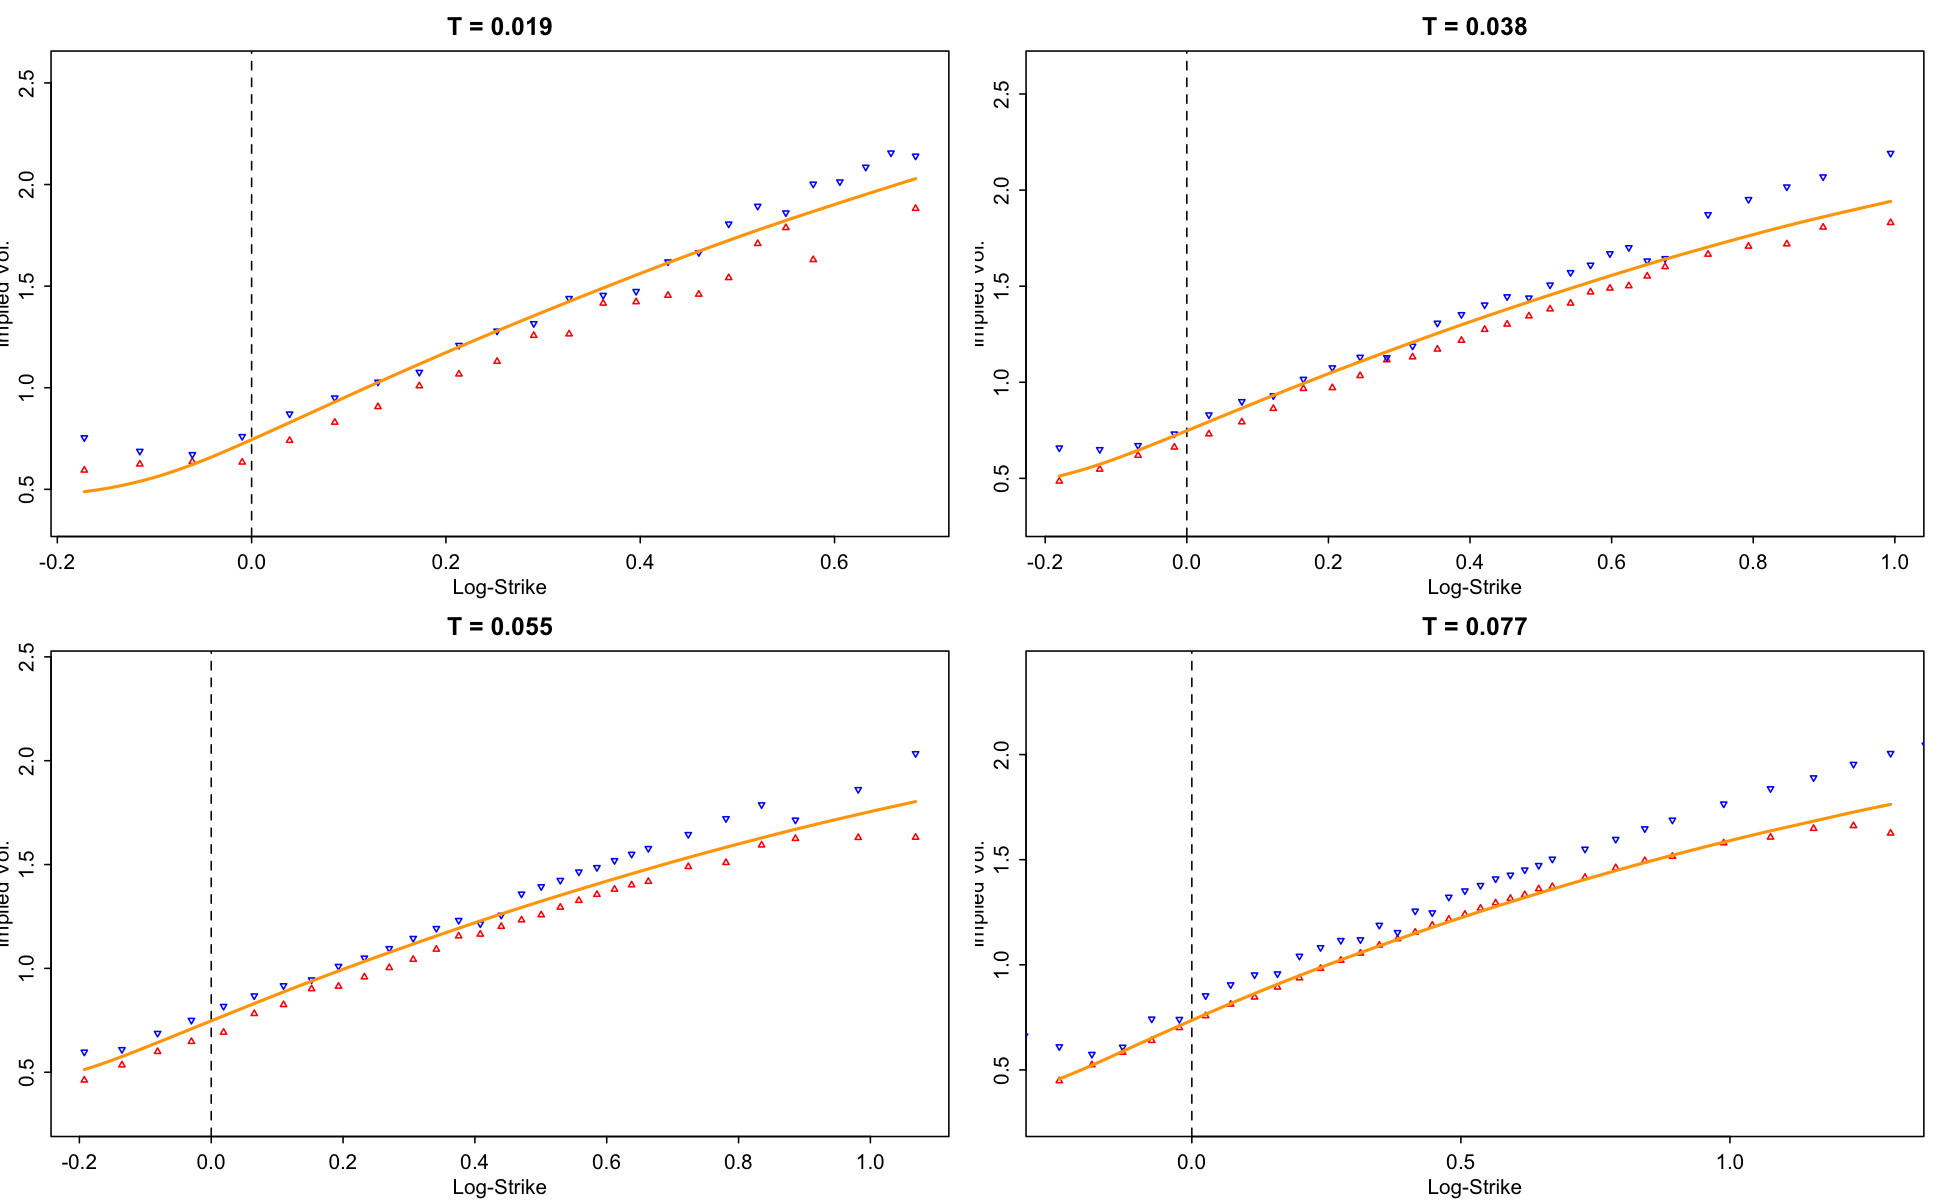

In [51]:
plot.vix <- plotIvolsMC(vixVolDataExtract, colnum = 2, mcMatrix = qrh.vix)
